In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [115]:
df = pd.read_csv(r'D:\2.WORK_DAILY\4.eKGIS_Data Science\Water\data\iot_water_thanhhoa.csv')

C:\Users\phamv\AppData\Local\Temp\ipykernel_1464\3324679782.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'D:\2.WORK_DAILY\4.eKGIS_Data Science\Water\data\iot_water_thanhhoa.csv')


In [116]:
df['datetime'] = pd.to_datetime(df['ts'], unit='s')
list_deviceid = ['66d92f94b7f41dd37df0634a',
'66d92fabb7f41dd37df06351',
'66d92fc2b7f41dd37df06355',
'66d92fc6b7f41dd37df06359',
'66d92fcbb7f41dd37df0635d',
'66d92fcfb7f41dd37df06361']
filter_df = df[df['deviceid'].isin(list_deviceid)]
filter_df = filter_df[['deviceid','datetime','dbl_v','parameter_key']]


In [117]:
filter_df = filter_df[filter_df['deviceid'] == '66d92f94b7f41dd37df0634a']
filter_df = filter_df[filter_df['parameter_key'] == 'P']

In [118]:
df_deviceid =  filter_df[['datetime','dbl_v']]

In [119]:
df_deviceid['second'] = df_deviceid['datetime'].dt.second
df_deviceid['minute'] = df_deviceid['datetime'].dt.minute
df_deviceid['hour']   = df_deviceid['datetime'].dt.hour

df_deviceid['minute'] = df_deviceid['minute'] + df_deviceid['hour']*60
df_deviceid['second'] = df_deviceid['second'] + df_deviceid['minute']*60
df_deviceid['day'] = df_deviceid['datetime'].dt.day

display(df_deviceid.head())

C:\Users\phamv\AppData\Local\Temp\ipykernel_1464\55102413.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deviceid['second'] = df_deviceid['datetime'].dt.second


,datetime,dbl_v,second,minute,hour,day
0,2024-09-16 00:00:18,2.327,18,0,0,16
1,2024-09-16 00:00:28,2.314,28,0,0,16
2,2024-09-16 00:00:38,2.312,38,0,0,16
3,2024-09-16 00:00:48,2.302,48,0,0,16
4,2024-09-16 00:00:58,2.338,58,0,0,16


In [120]:
def SensorViz(df, feature_X, feature_y, savefig = False):
    plt.figure(figsize=(18,5))
    plt.scatter(df[feature_X],df[feature_y])
    plt.plot(df[feature_X],df[feature_y])
    plt.title(f'{feature_X} Vs {feature_y}', size = 20)
    plt.xlabel(feature_X, size = 20)
    plt.ylabel(feature_y, size = 20)
    plt.grid()

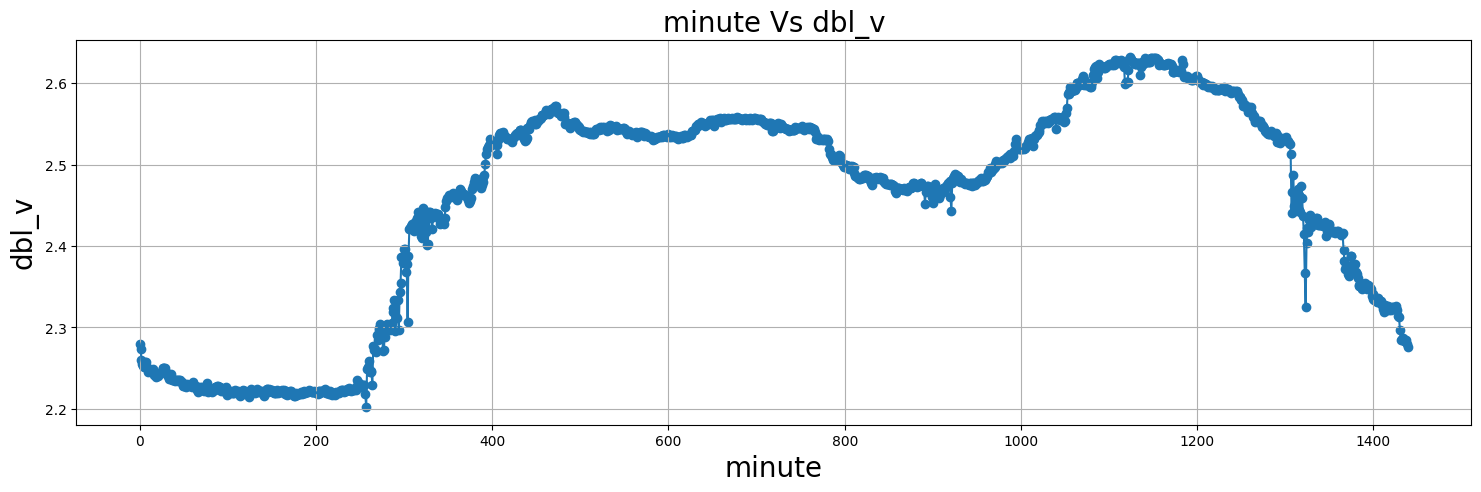

In [121]:
feature_y = 'dbl_v'
feature_X = 'minute'
data_group = df_deviceid[[feature_X, feature_y]].groupby(feature_X, as_index=False).mean()
SensorViz(data_group, feature_X, feature_y)

**Model**

In [122]:
feature_X = 'minute'
feature_y = 'dbl_v'
data_group = df_deviceid[[feature_X, feature_y]].groupby(feature_X,as_index=False).mean()
X=data_group[[feature_X]].values
y=data_group[feature_y].values

In [123]:
# Tạo  các đặc trưng đa thức với bậc 5
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree = 5)
X_poly = poly_reg.fit_transform(X)
print(X_poly[:6])

[[1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [1.000e+00 2.000e+00 4.000e+00 8.000e+00 1.600e+01 3.200e+01]
 [1.000e+00 3.000e+00 9.000e+00 2.700e+01 8.100e+01 2.430e+02]
 [1.000e+00 4.000e+00 1.600e+01 6.400e+01 2.560e+02 1.024e+03]
 [1.000e+00 5.000e+00 2.500e+01 1.250e+02 6.250e+02 3.125e+03]]


In [124]:
#Huấn luyện mô hình 
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)

LinearRegression()

In [125]:
print("Incorrect Input :", X_poly[0])
print("Correct Input :", X_poly[0].reshape(1, -1))
print("Output : ", lin_reg.predict(X_poly[0].reshape(1, -1)))

Incorrect Input : [1. 0. 0. 0. 0. 0.]
Correct Input : [[1. 0. 0. 0. 0. 0.]]
Output :  [2.29724922]


In [126]:
y_predict = lin_reg.predict(poly_reg.fit_transform(X)) # Sử dụng transform thay vì fit_transform

<Figure size 2000x500 with 0 Axes>

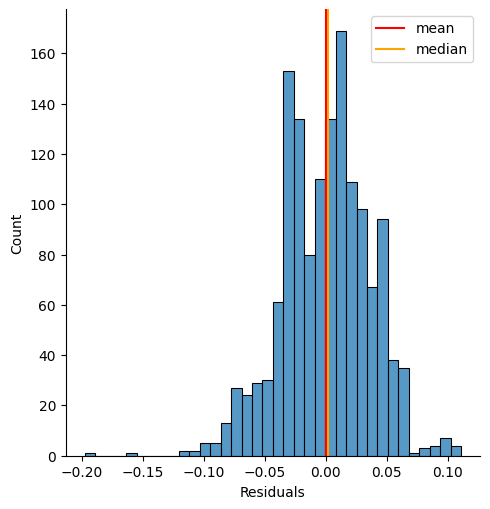

In [127]:
# Tính toán residual (phần dư)
residuals = y - y_predict
plt.figure(figsize=(20,5))
sns.displot(residuals)
plt.axvline(x = np.mean(residuals), color = 'red', label = 'mean')
plt.axvline(x = np.median(residuals), color = 'orange', label = 'median')
plt.xlabel("Residuals")
plt.legend(loc = "upper right")
plt.show()

In [128]:
# Tính toán độ lệch chuẩn và từ đó tính toán được ngưỡng trên ngưỡng dưới
std = np.std(residuals) 
y_predict_upBound = y_predict + 3*std
y_predict_lowBound = y_predict - 3*std

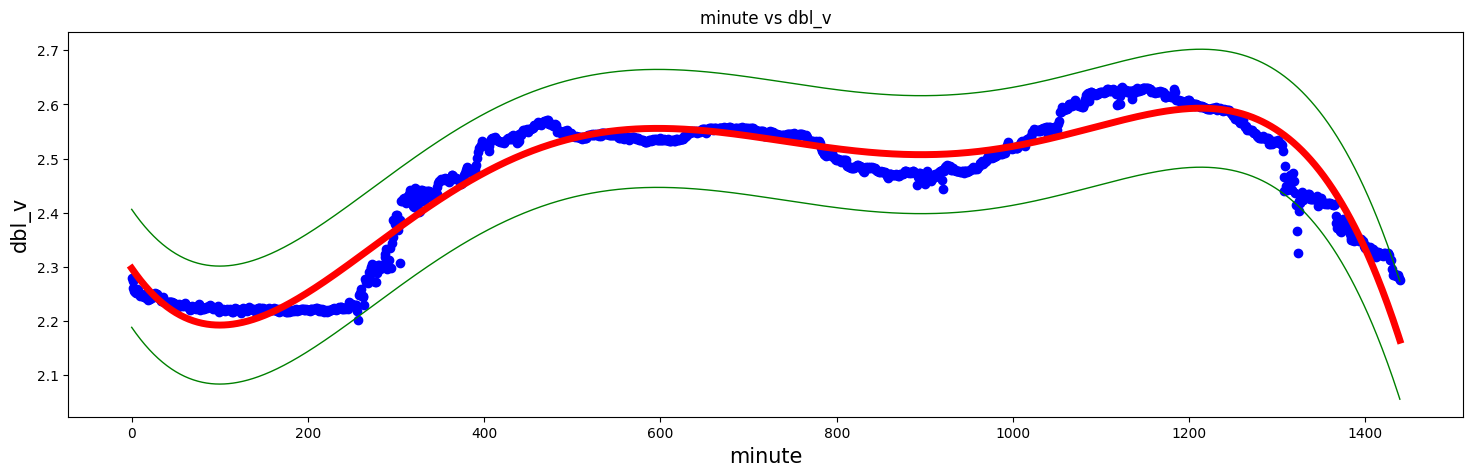

In [129]:
plt.figure(figsize=(18, 5))
plt.scatter(X,y, color = "blue")
plt.plot(X, y_predict, color = "red", linewidth = 5)
plt.plot(X, y_predict_upBound, color = "green", linewidth = 1)
plt.plot(X, y_predict_lowBound, color = "green", linewidth = 1)
plt.title(f"{feature_X} vs {feature_y}")
plt.xlabel(feature_X, size = 15)
plt.ylabel(feature_y, size = 15)
plt.show()

In [130]:
LogDF = pd.DataFrame(columns = ["minute", "true_temp", "predicted_temp", "conf_lower", "conf_upper"])
LogDF["minute"] = X.reshape(-1)
LogDF["true_temp"] = y
LogDF["predicted_temp"] = y_predict
LogDF["conf_lower"] = y_predict_lowBound
LogDF["conf_upper"] = y_predict_upBound
LogDF["Alarm"] = (LogDF["true_temp"] < LogDF["conf_lower"]) | (LogDF["true_temp"] > LogDF["conf_upper"])
display(LogDF.head())
print("Alarm Time : ")
print(LogDF[LogDF["Alarm"] == True])

,minute,true_temp,predicted_temp,conf_lower,conf_upper,Alarm
0,0,2.280289,2.297249,2.188291,2.406208,False
1,1,2.273920,2.294897,2.185939,2.403856,False
2,2,2.260224,2.292578,2.183619,2.401536,False
3,3,2.254607,2.290290,2.181331,2.399249,False
4,4,2.253139,2.288034,2.179075,2.396992,False


Alarm Time : 
      minute  true_temp  predicted_temp  conf_lower  conf_upper  Alarm
257      257   2.202121        2.317112    2.208154    2.426071   True
1321    1321   2.414869        2.525412    2.416453    2.634371   True
1322    1322   2.366732        2.523922    2.414963    2.632881   True
1323    1323   2.324923        2.522412    2.413453    2.631370   True
1324    1324   2.403506        2.520880    2.411922    2.629839   True
1437    1437   2.285146        2.174461    2.065503    2.283420   True
1438    1438   2.279181        2.169473    2.060514    2.278431   True
1439    1439   2.275586        2.164443    2.055484    2.273402   True


**Lưu và triển khai thử mô hình**

In [131]:
import joblib
joblib.dump(lin_reg,'linear_regression_model66d92f94b7f41dd37df0634a.pkl')
joblib.dump(poly_reg,'polynomial_features66d92f94b7f41dd37df0634a.pkl')

['polynomial_features66d92f94b7f41dd37df0634a.pkl']

In [132]:
#tải lại model
import joblib
lin_reg_load = joblib.load('linear_regression_model66d92fabb7f41dd37df06355.pkl')
poly_reg_load = joblib.load('polynomial_features66d92fabb7f41dd37df06355.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'linear_regression_model66d92fabb7f41dd37df06355.pkl'

In [103]:
#dự đoán thử
import numpy as np
new_X = np.array([[10], [20], [30]])  # Ví dụ
new_X_poly = poly_reg_load.transform(new_X)
new_y_pred = lin_reg_load.predict(new_X_poly)
print(new_y_pred)

[2.439237   2.41140525 2.38748039]


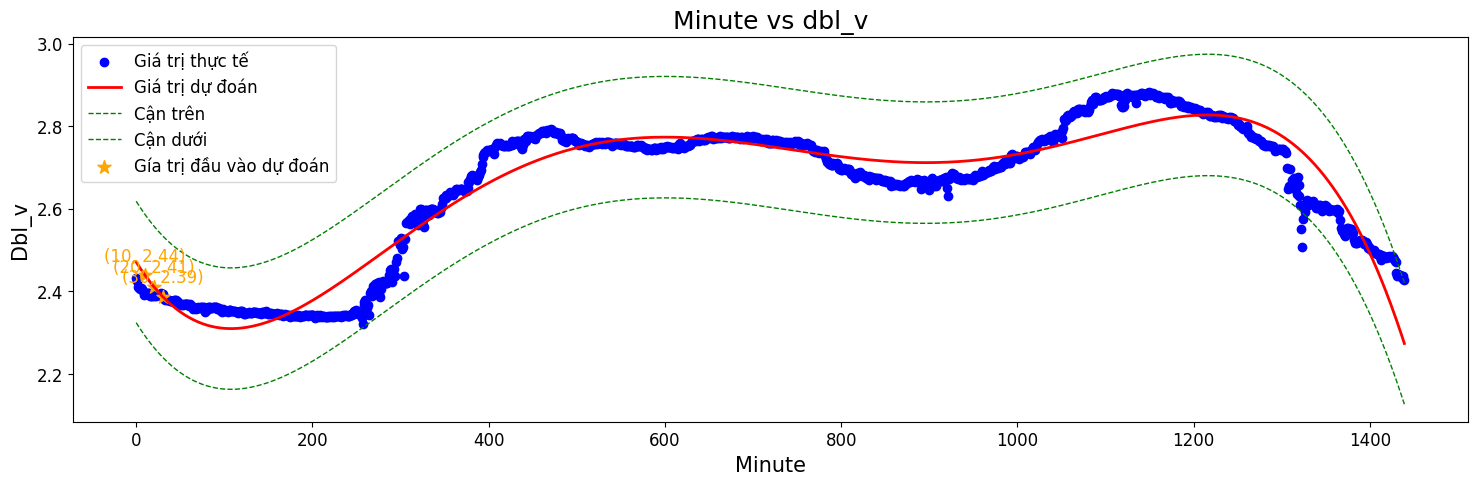

In [104]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 5))
plt.scatter(X, y, color="blue", label='Giá trị thực tế')

plt.plot(X, y_predict, color="red", linewidth=2, label='Giá trị dự đoán')
plt.plot(X, y_predict_upBound, color="green", linewidth=1, linestyle='--', label='Cận trên')
plt.plot(X, y_predict_lowBound, color="green", linewidth=1, linestyle='--', label='Cận dưới')
plt.scatter(new_X, new_y_pred, color='orange', marker='*', s=100, label='Gía trị đầu vào dự đoán')

for i, (x_val, y_val) in enumerate(zip(new_X.flatten(), new_y_pred)):
    plt.annotate(f'({x_val}, {y_val:.2f})', 
                 (x_val, y_val), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center',
                 fontsize=12,
                 color='orange')

plt.title(f"{feature_X.capitalize()} vs {feature_y}", fontsize=18)
plt.xlabel(feature_X.capitalize(), size=15)
plt.ylabel(feature_y.capitalize(), size=15)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()